# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [362]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set()


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', dtype={18:'str',19:'str'}, index_col=0)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', dtype={18:'str',19:'str'}, index_col=0)

### a) View data

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
print('azidas shape:',azdias.shape)
print('customer shape:',customers.shape)

azidas shape: (891221, 366)
customer shape: (191652, 369)


In [6]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [7]:
# Check for the extra columns in customer
customers_additional_features = set(customers.columns.tolist()) - set(azdias.columns.tolist())
print(customers_additional_features)
# store extra columns
customers_ex_cols = customers[customers_additional_features]
# drop extra columns
customers.drop(columns=customers_additional_features, axis=1, inplace=True)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}


In [8]:
# Concat Two columns for plotting
azplot = azdias
cuplot = customers
azplot['dataset'] = 'Azdias'
cuplot['dataset'] = 'Customers'
df = pd.concat([azplot, cuplot])

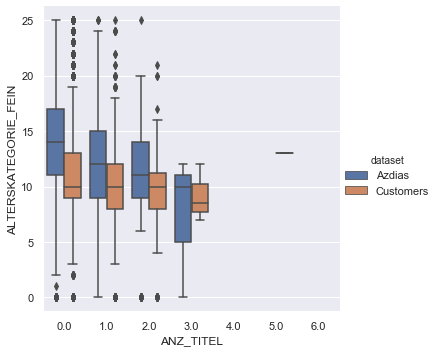

In [9]:
sns.catplot(x="ANZ_TITEL", y="ALTERSKATEGORIE_FEIN", hue="dataset",
            kind="box", dodge=True, data=df);

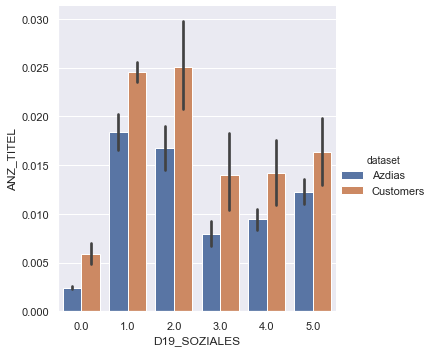

In [10]:
sns.catplot(x="D19_SOZIALES", y="ANZ_TITEL", hue="dataset", 
            kind="bar", data=df)

### b) Process missing data

**Missing data in columns**

In [2]:
def get_feature_info():
    """
    get feature infos from Excel Attributes sheet
    transform infos to DataFrame with information for missing and unknown data
    OUTPUT: Dataframe
    """
    feat_info = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1)
    del feat_info['Unnamed: 0']
    # Fill out feature attribute column
    feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
    # Identify NaN values
    feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
    # Convert the info to a list of NaN placeholders
    feat_info_nan = []
    for attribute in feat_info['Attribute'].unique():
        NaNs = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',').split(',')
        feat_info_nan.append(NaNs)
    feat_info_nan = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(feat_info_nan)], axis=1)
    feat_info_nan.columns = ['Attribute', 'NaN']
    return feat_info_nan

In [3]:
def conv_nan_del_extra_col(df):
    """
    Converts the missing und unknown data to NaN
    returns just the columns represented in the description data
    INPUT: DataFrame
    OUTPUT: DataFrame
    """
    print("Convert Missing to NaN")
    feat_info_nans = get_feature_info()
    
    attributes = list(feat_info_nans.Attribute)
    if 'dataset' in df.columns:
        attributes.append('dataset')
    if 'RESPONSE' in df.columns:
        attributes.append('RESPONSE')
    
    for row in feat_info_nans['Attribute']:
        if row in df.columns:
            na_map = feat_info_nans.loc[feat_info_nans['Attribute'] == row, 'NaN'].iloc[0]
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else: continue
            
    return df.loc[:,attributes]

In [4]:
def conv_nan(df):
    """
    Converts the missing und unknown data to NaN
    INPUT: DataFrame
    OUTPUT: DataFrame
    """
    print("Convert Missing to NaN")
    feat_info_nans = get_feature_info()
   
    for row in feat_info_nans['Attribute']:
        if row in df.columns:
            na_map = feat_info_nans.loc[feat_info_nans['Attribute'] == row, 'NaN'].iloc[0]
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else: continue
    # Recode 10's to 0 for D19 columns that need it
    recode = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM']
    df[recode] = df[recode].replace(10, 0)
      
    return df

In [14]:
df = conv_nan_del_extra_col(df)

Convert Missing to NaN


In [5]:
def prop_show(prop, kind='Columns'):
    """
    plot a histogramm of the null-proportions
    INPUT: prop (df): a dataframe with propportions 
    """
    plt.figure(figsize=(10,5))
    plt.title('Distribution of Missing Data Across {} \n'.format(kind), size=16, loc='left')
    sns.distplot(prop)
    plt.xlabel('Proportion of Missing Data')
    plt.ylabel('Count')
    plt.show()

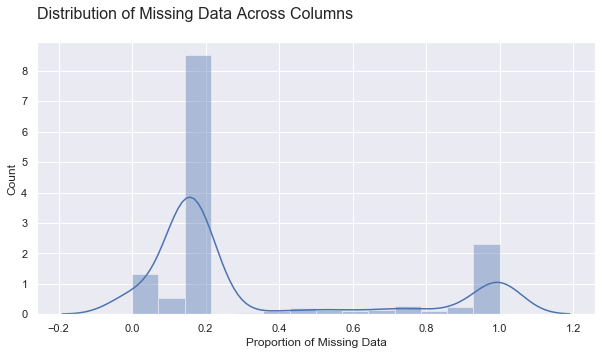

In [16]:
# Perform an assessment of how much missing data there is in each column of the dataset.
null_prop = df.isnull().sum() / len(df)
prop_show(null_prop)

In [6]:
# Remove the outlier columns from the dataset.
def outlier_col_drop(df,prop=0.80):
    """
    Remove the outlier columns from the dataset.
    INPUT: dataframe, proportion of NaN in the dataframe as filter
    OUTPUT: converted dataframe, list with columns to drop from feature info
    """
    print("Drop Columns with NaN")
    null_prop = df.isnull().sum() / len(df)
    drop_list = list(null_prop[null_prop > prop].index)
    print("outlier_col_drop: {}".format(drop_list))
    df_d = df.drop(columns=drop_list, axis = 1)
    
    return df_d

In [18]:
df = outlier_col_drop(df)

Drop Columns with NaN
outlier_col_drop: ['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_VERSI_

**Missing data in rows**

In [19]:
# How much data is missing in each row of the dataset?
df['Row_NaN_%'] = df.isnull().sum(axis=1) / df.shape[1]

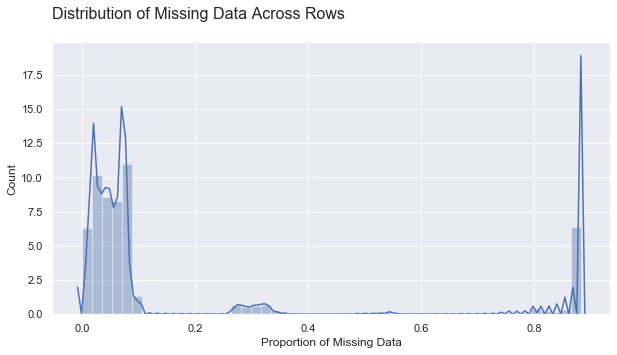

In [20]:
prop_show(df['Row_NaN_%'], kind="Rows")

In [7]:
# Remove the outlier rows from the dataset.
def outlier_row_drop(df,prop=0.7):
    """
    Remove the outlier rows from the dataset. 
    INPUT: dataframe, proportion of NaN in the dataframe as filter
    OUTPUT: converted dataframe, list with columns to drop from feature info
    """
    print("Drop Roes with NaN")
    df = df[df['Row_NaN_%']<0.65]
    df.drop(columns='Row_NaN_%', axis = 1)
    return df

In [22]:
print('number of rows in new dataset befor drop: ',df.shape)
df = outlier_row_drop(df)
print('number of rows in new dataset after drop: ',df.shape)

number of rows in new dataset befor drop:  (1082873, 239)
Drop Roes with NaN
number of rows in new dataset after drop:  (932108, 239)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932108 entries, 1 to 191651
Columns: 239 entries, AGER_TYP to Row_NaN_%
dtypes: float64(236), object(3)
memory usage: 1.7+ GB


### c) Encoding Categorical and Mixed Columns

**Enconding categorical comuns**

* Manually looked up in the Excel information sheet

In [24]:
cat_cols = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB',
'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'SHOPPER_TYP', 
'SOHO_FLAG', 'WOHNLAGE', 'TITEL_KZ', 'VERS_TYP']

In [8]:
def del_fein(df):
    """
    Delete "FEIN" columns - redundant to the more precice "GROB"-columns
    INPUT: dataframe
    OUTPUT: dataframe, list of columns to drop
    """
    drop_list = [col for col in df.columns if "FEIN" in col]
    df_d = df.drop(drop_list, axis=1)
    return df_d

In [283]:
def cat_encode(df, cat_cols):
    """
    search for categorical columns with more then two categories and reencode with one-hot-encoding
    INPUT: dataframe: the data
           cat_cols: list of categorical columns in the data 
    OUTPUT: reencoded dataframe
    """
    print("categorical encoding")
    df = del_fein(df)
    cols = df.columns
    dummie_list = [cat for cat in cols if cat not in cat_cols]
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    print("cat_encode: {}".format(dummie_list))
    df_dumm = pd.get_dummies(df, columns = dummie_list)
    return df_dumm

In [27]:
df = cat_encode(df, cat_cols)

categorical encoding
cat_encode: ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'SHOPPER_TYP', 'WOHNLAGE', 'VERS_TYP']


**Reencode 'PRAEGENDE JUGENDJAHRE'**

In [10]:
def pj_features(df):
    """
    Converts the "PRAEGENDE JUGENDJAHRE" into three new variables
    PJ_DEKADE: ordinal data - decade
    PJ_BEWEGUNG: categorical data with two categories
    PJ_STAAT: German Nation (east, west or both - one hot encoded)
    
    INPUT: dataframe
    OUTPUT: converted dataframe
    """
    print("PJ feature adaptation")
    
    _40 = [1.0,2.0]
    _50 = [3.0,4.0]
    _60 = [5.0,6.0,7.0]
    _70 = [8.0,9.0]
    _80 = [10.0,11.0,12.0,13.0]
    main = [1.0,3.0,5.0,8.0,10.0,12.0]
    e = [7.0,12.0,13.0]
    w = [6.0,10.0,11.0]
    col = "PRAEGENDE_JUGENDJAHRE"
    if not col in df.columns: 
        return df
    for i in range(1,16):
        i = float(i)
        # New Feature PJ_DEKADE (Decade)
        if i in _40:
            df.loc[df[col]==i,"PJ_DEKADE"] = 0
        elif i in _50:
            df.loc[df[col]==i,"PJ_DEKADE"] = 1
        elif i in _60:
            df.loc[df[col]==i,"PJ_DEKADE"] = 2
        elif i in _70:
            df.loc[df[col]==i,"PJ_DEKADE"] = 3
        elif i in _80:
            df.loc[df[col]==i,"PJ_DEKADE"] = 4
        else:
            df.loc[df[col]==i,"PJ_DEKADE"] = 5
        # New Feature PJ_BEWEGUNG (Movement)
        if i in main:
            df.loc[df[col]==i,"PJ_BEWEGUNG"] = 0
        else: 
            df.loc[df[col]==i,"PJ_BEWEGUNG"] = 1
        # New Feature PJ_STAAT (German Nation)
        if i in e:
            df.loc[df[col]==i,"PJ_STAAT"] = 0
        elif i in w:
            df.loc[df[col]==i,"PJ_STAAT"] = 1
        else: 
            df.loc[df[col]==i,"PJ_STAAT"] = 2
        # one hot encoding:
        df = pd.get_dummies(df, columns = ["PJ_STAAT"])
    return df.drop(col,axis=1)

In [29]:
df = pj_features(df)

PJ feature adaptation


In [30]:
df.dataset[:10]

1     Azdias
2     Azdias
3     Azdias
4     Azdias
5     Azdias
6     Azdias
7     Azdias
8     Azdias
9     Azdias
10    Azdias
Name: dataset, dtype: object

### e) Cleaning Functions

**For Unsupervised Learning**

In [11]:
def clean_data(df1, df2=pd.DataFrame()):
    """
    Combination of all clean up functions
    For one or two Dataframes
    INPUT: df1 - DataFrame one
           df2 - Dataframe two (default = "")
    OUTPUT: Cleaned up DataFrame one and two
    """
    if len(df2) > 0:
        # Check for the extra columns in customer
        customers_additional_features = set(df1.columns.tolist()) - set(df2.columns.tolist())
        # drop extra columns
        df2.drop(columns=customers_additional_features, axis=1, inplace=True)
        # Concat Two columns for plotting
        df1['dataset'] = 'df1'
        df2['dataset'] = 'df2'
        df = pd.concat([df1, df2])
    else:
        df = df1
    
    print('Shape of dataset befor clean up: ',df.shape)
    
    df = df.apply(lambda x: x.replace('XX', np.nan))
    df = df.apply(lambda x: x.replace('X', np.nan))
    
    df = conv_nan_del_extra_col(df)
    df = outlier_col_drop(df)
    df['Row_NaN_%'] = df.isnull().sum(axis=1) / df.shape[1]
    df = outlier_row_drop(df)
    cat_cols = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
    'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
    'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
    'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
    'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'SHOPPER_TYP', 
    'SOHO_FLAG', 'WOHNLAGE', 'TITEL_KZ', 'VERS_TYP']
    df = cat_encode(df, cat_cols)
    df = pj_features(df)
    if 'EINGEFUEGT_AM' in df.columns:
        del df['EINGEFUEGT_AM']
    print('Shape of dataset after clean up: ',df.shape)
    
    if len(df2) > 0:
        # Concat Two columns for plotting
        df1 = df[df['dataset'] == 'df1']
        df2 = df[df['dataset'] == 'df2']
        del df1['dataset']
        del df2['dataset']
        return df1, df2
    else:
        return df

**For Supervised Learning**

In [371]:
def clean_data_svl(df1, df2=pd.DataFrame()):
    """
    Combination of all clean up functions
    
    INPUT: df1 - DataFrame one
           df2 - Dataframe two (default = "")
    OUTPUT: Cleaned up DataFrame one and two
    """
    if len(df2) > 0:
        # Check for the extra columns in customer
        customers_additional_features = set(df1.columns.tolist()) - set(df2.columns.tolist())
        # drop extra columns
        df2.drop(columns=customers_additional_features, axis=1, inplace=True)
        # Concat Two columns for plotting
        df1['dataset'] = 'df1'
        df2['dataset'] = 'df2'
        df1['WEALTH'] = df1.CAMEO_INTL_2015[df1.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
        df1['LIFE_STAGE'] = df1.CAMEO_INTL_2015[df1.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
        df2['WEALTH'] = df2.CAMEO_INTL_2015[df2.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
        df2['LIFE_STAGE'] = df2.CAMEO_INTL_2015[df2.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
        df = pd.concat([df1, df2])
    else:
        df1['WEALTH'] = df1.CAMEO_INTL_2015[df1.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
        df1['LIFE_STAGE'] = df1.CAMEO_INTL_2015[df1.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
        df = df1
   
    print('Shape of dataset befor clean up: ',df.shape)
    del df['CAMEO_INTL_2015']
    df = conv_nan(df)
    df = outlier_col_drop(df)
    
    df = df.apply(lambda x: x.replace('XX', np.nan))
    df = df.apply(lambda x: x.replace('X', np.nan))
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
    cat_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_PERSONEN',
                'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW', 
                'MIN_GEBAEUDEJAHR', 'EINGEFUEGT_AM', 'dataset']
    df = cat_encode(df, cat_cols)
    df = pj_features(df)
    #df['WEALTH'] = [str(x)[0] for x in df.CAMEO_INTL_2015 if not math.isnan(x)]
    #df['LIFE_STAGE'] = [str(x)[1] for x in df.CAMEO_INTL_2015 if not math.isnan(x)]
    #df['WEALTH'] = df.CAMEO_INTL_2015[df.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
    #df['LIFE_STAGE'] = df.CAMEO_INTL_2015[df.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
    
    #del df['CAMEO_INTL_2015']
    if 'EINGEFUEGT_AM' in df.columns:
        del df['EINGEFUEGT_AM']
    
    print('Shape of dataset after clean up: ',df.shape)
    
    if len(df2) > 0:
        # Concat Two columns for plotting
        df1 = df[df['dataset'] == 'df1']
        df2 = df[df['dataset'] == 'df2']
        del df1['dataset']
        del df2['dataset']
        return df1, df2
    else:
        return df

In [13]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', dtype={18:'str',19:'str'}, index_col=0)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', dtype={18:'str',19:'str'}, index_col=0)

#apply cleaning
azdias_clean, customers_clean = clean_data(azdias, customers)

Shape of dataset befor clean up:  (1082873, 370)
Convert Missing to NaN
Drop Columns with NaN
outlier_col_drop: ['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST_RZ', 'D19_TIER

In [14]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,...,PJ_STAAT_1.0,PJ_STAAT_0.0,PJ_STAAT_2.0,PJ_STAAT_2.0,PJ_STAAT_1.0,PJ_STAAT_1.0,PJ_STAAT_0.0,PJ_STAAT_0.0,PJ_STAAT_2.0,PJ_STAAT_2.0
1,1.0,NaN,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2,3.0,17.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
3,4.0,13.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,3.0,20.0,2.0,6.0,5.0,6.0,6.0,1.0,6.0,1.0,...,0,0,1,0,0,0,0,0,0,0
5,1.0,10.0,6.0,8.0,NaN,1.0,1.0,3.0,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
azdias_clean.to_csv("data/azdias_clean.csv")
customers_clean.to_csv("data/customers_clean.csv")

### f) Feature scaling

In [16]:
def feat_transform(df):
    """
    Impute median for missing values and scaling of the data
    INPUT: dataframe
    OUTPUT scaled dataframe
    """
    print("feat_transform")
    imp = SimpleImputer(missing_values=float("NaN"), strategy="median", copy = False)
    scale = StandardScaler()
    X = imp.fit_transform(df)
    X = pd.DataFrame(scale.fit_transform(X))
    X.columns = df.columns
    X.index = df.index
    return X

In [17]:
#del azdias_clean['D19_LETZTER_KAUF_BRANCHE']
azdias_clean = pd.read_csv('data/azdias_clean.csv')
azdias_scaled = feat_transform(azdias_clean)

feat_transform


* I used median as strategy, because it is more prone against outliers. 
* I also ensured to keep the Dataframe type for further steps.
* As Scaler I used the StandardScaler from scikit learn to replace the values by their Z score
* This strategy is well suited for a zero centric algorithm like PCA

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### a) Perform Dimensionality Reduction

- I use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
- For start, no parameters are set manuelly (so all components are computed) or number of components are reduced manually (so there's enough features to see the general trend in variability).

In [18]:
def do_pca(data, n_components, tf=False):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    if tf:
        X = StandardScaler().fit_transform(data)    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [19]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of instantian of PCA in scikit learn      
    OUTPUT:None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component \n', size=16, loc='left')

In [20]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    # Return a concatenated DataFrame
    df =  pd.concat([variance_ratios, components], axis = 1)
    return df

**Applying PCA**

In [21]:
# Start searching for a good number of components at 50
for comp in range(100, azdias_scaled.shape[1]):
    pca_test, X_pca_test = do_pca(azdias_scaled, comp)
    comp_check = pca_results(azdias_scaled, pca_test)
    if comp%10 == 0:
        print("N_Components tested: {}; with explained variance of {}".format(comp, comp_check['Explained Variance'].sum()))
    if comp_check['Explained Variance'].sum() > 0.85:
        break
        
num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(
    num_comps,comp_check['Explained Variance'].sum()*100))

# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(azdias_scaled, num_comps)

# Checking the final results
comp_check = pca_results(azdias_scaled, pca)

N_Components tested: 100; with explained variance of 0.7682
N_Components tested: 110; with explained variance of 0.7979000000000002
N_Components tested: 120; with explained variance of 0.8253
N_Components tested: 130; with explained variance of 0.8503000000000001
Using 130 components, we can explain 85.03% of the variability in the original data.


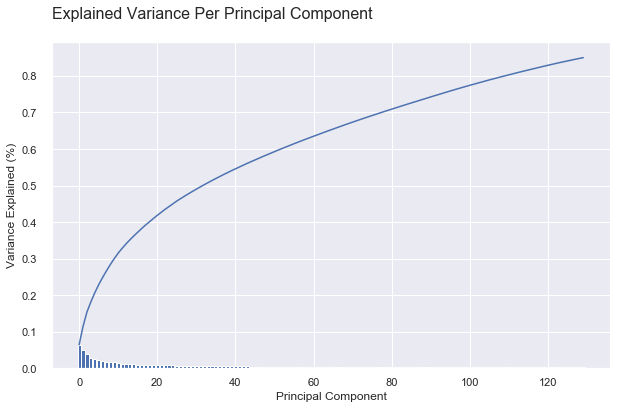

In [22]:
# The pca components test
scree_plot(pca_test)

N_Components tested: 100; with explained variance of 0.7682  
N_Components tested: 110; with explained variance of 0.7979000000000002  
N_Components tested: 120; with explained variance of 0.8253  
N_Components tested: 130; with explained variance of 0.8503000000000001  
**Using 130 components, we can explain 85.03% of the variability in the original data.** 

To get to this result I used the following steps:
* Iteration over the range of the columns of the prepaired dataset for the number of components
* Apply the pca-algorithm to get the principal components for each iteration
* Calculate the dimensions and the cummulative explained variance for the iteration
* Check if the explained variance is higher than 85%
* Stop the process at the 85%
* Re-apply the pca algorithm with the selected number of components. 

### b) Interpreting Principal Components Analysis

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, we map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Using the data dictionary document to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.  

Further we investigate and interpret feature associations from the first three principal components.

In [23]:
comp_check.head()

,Explained Variance,Unnamed: 0,ALTERSKATEGORIE_GROB,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,...,PJ_STAAT_1.0,PJ_STAAT_0.0,PJ_STAAT_2.0.5,PJ_STAAT_2.0.6,PJ_STAAT_1.0.1,PJ_STAAT_1.0.2,PJ_STAAT_0.0.1,PJ_STAAT_0.0.2,PJ_STAAT_2.0.7,PJ_STAAT_2.0.8
Dimension 1,0.0641,-0.0038,0.0308,-0.0081,0.0093,-0.1275,-0.0113,0.0153,0.0104,-0.0208,...,0.0438,0.0010,-0.0130,0.0420,-0.0010,0.0407,-0.0500,-0.0057,-0.0492,0.0389
Dimension 2,0.0504,-0.0021,-0.0610,0.0216,-0.1361,0.1036,0.0093,-0.0201,-0.0132,0.0221,...,-0.0084,-0.0108,-0.0137,-0.0062,0.0158,0.0047,-0.0129,-0.0054,0.0417,0.0187
Dimension 3,0.0394,0.0011,0.2055,-0.1788,-0.0382,0.0273,0.0358,-0.0575,-0.0611,0.0517,...,0.0463,0.0232,0.0401,0.0203,-0.0467,-0.0195,-0.0056,-0.0022,-0.1685,-0.0703
Dimension 4,0.0275,0.0073,-0.0573,0.0329,0.0177,-0.0349,-0.0167,0.0272,0.0248,-0.0272,...,-0.0025,0.0356,-0.0376,0.0209,-0.0556,0.0127,0.0717,0.0483,0.0448,0.0329
Dimension 5,0.0250,0.0003,0.0235,-0.0440,-0.0137,0.0079,0.0035,-0.0405,-0.0467,0.0306,...,0.0214,0.0052,0.0059,0.0027,-0.0107,0.0051,-0.0066,0.0046,-0.0483,0.0069


In [24]:
def print_weights(results,n_comp=1):
    '''
    n: number of principal component
    results: ouput from pca_results
    '''
    components = results.iloc[n_comp-1:n_comp,1:]
    components = components.T
    components_pos = components.sort_values(by = 'Dimension {}'.format(n_comp) ,ascending=False)[:10]
    components_neg = components.sort_values(by = 'Dimension {}'.format(n_comp) ,ascending=True)[:10]
    # The results
    print("Most Positive Values\n\n", components_pos)
    print("\nMost Negative Values\n\n", components_neg)

In [25]:
# Map weights for the first principal component to corresponding feature names
print_weights(comp_check)

Most Positive Values

                              Dimension 1
KBA13_HERST_BMW_BENZ              0.1316
KBA13_MERCEDES                    0.1191
OST_WEST_KZ_1                     0.1172
KBA13_SEG_GELAENDEWAGEN           0.1166
PLZ8_ANTG1                        0.1148
KBA05_HERST1                      0.1112
KBA13_SITZE_6                     0.1094
KBA05_MOTOR                       0.1084
KBA05_KW3                         0.1065
KBA13_SEG_OBEREMITTELKLASSE       0.1056

Most Negative Values

                          Dimension 1
HH_EINKOMMEN_SCORE           -0.1336
CAMEO_DEUG_2015              -0.1275
KBA13_ALTERHALTER_30         -0.1221
OST_WEST_KZ_0                -0.1172
KBA13_SITZE_5                -0.1159
KBA13_SEG_KOMPAKTKLASSE      -0.1155
KBA13_HALTER_30              -0.1139
KBA13_SEG_KLEINWAGEN         -0.1100
KBA13_KW_0_60                -0.1095
KBA13_HALTER_25              -0.1072


In [26]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(comp_check,2)

Most Positive Values

                              Dimension 2
EWDICHTE                          0.1919
ORTSGR_KLS9                       0.1809
PLZ8_ANTG3                        0.1582
PLZ8_ANTG4                        0.1519
KBA13_HERST_BMW_BENZ              0.1382
PLZ8_ANTG2                        0.1288
KBA13_SEG_OBEREMITTELKLASSE       0.1279
KBA13_SITZE_4                     0.1218
KBA13_BMW                         0.1209
KBA05_BAUMAX                      0.1129

Most Negative Values

                       Dimension 2
KBA13_ALTERHALTER_60      -0.1774
KBA13_AUTOQUOTE           -0.1651
KBA13_HALTER_55           -0.1613
KBA13_HALTER_50           -0.1548
INNENSTADT                -0.1483
PLZ8_ANTG1                -0.1457
KBA05_AUTOQUOT            -0.1396
KBA13_HALTER_20           -0.1366
BALLRAUM                  -0.1361
KBA13_HALTER_60           -0.1322


In [27]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(comp_check,3)

Most Positive Values

                       Dimension 3
FINANZ_VORSORGER           0.2102
ALTERSKATEGORIE_GROB       0.2055
SEMIO_ERL                  0.1649
SEMIO_LUST                 0.1578
RETOURTYP_BK_S             0.1464
AGER_TYP_2.0               0.1186
W_KEIT_KIND_HH             0.1078
CJT_GESAMTTYP_2.0          0.1035
FINANZTYP_5.0              0.0998
FINANZ_MINIMALIST          0.0992

Most Negative Values

                        Dimension 3
PJ_DEKADE                  -0.2372
FINANZ_SPARER              -0.2271
FINANZ_UNAUFFAELLIGER      -0.2070
FINANZ_ANLEGER             -0.2013
SEMIO_REL                  -0.2004
SEMIO_PFLICHT              -0.1980
SEMIO_TRADV                -0.1885
ALTER_HH                   -0.1788
PJ_STAAT_2.0.7             -0.1685
SEMIO_RAT                  -0.1586


**Principal 1**  

* The strongest positive feature weights: 
    + KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8
    + KBA13_MERCEDES: share of Mercedes Benz within the PLZ8
* The strongest negative feature weights:
    + HH_EINKOMMEN_SCORE: estimated household net income 
    + CAMEO_DEUG_2015: CAMEO classification 2015 - Uppergroup

**Principal 2**

* The strongest positive feature weights:
    + EWDICHTE: Einwohnerdichte im Wohnort
    + ORTSGR_KLS9: size of the community
* The strongest negative feature weights:
    + KBA13_ALTERHALTER_60: share of car owners between 46 and 60 within the PLZ8
    + KBA13_AUTOQUOTE: share of cars per household within the PLZ8

**Principal 3**

* The strongest positive feature weights:
    + FINANZ_VORSORGER is a type of person which wants to be prepared in the future
    + ALTERKATEGORIE GROB: Age Categories
* The strongest negative feature weights:
    + PJ_DEKADE is a constructed variable from the Prägende Jugendjahre column, which correlates to the age of a person
    + FINANZ_SPARER is a type of person which saves money for no particular reason 

### c) Clustering the General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

1. sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Computing the average difference from each point to its assigned cluster's center.
- Performing the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit.
- After selecting a final number of clusters to use, I re-fit a KMeans instance to perform the clustering operation.

In [28]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return score

In [29]:
# Apply Clustering
k_start = 5
k_end = 30
scores = []
for i in range(k_start, k_end):
    print("K: {}".format(i))
    scores.append(get_kmeans_score(X_pca, i))

K: 5
K: 6
K: 7
K: 8
K: 9
K: 10
K: 11
K: 12
K: 13
K: 14
K: 15
K: 16
K: 17
K: 18
K: 19
K: 20
K: 21
K: 22
K: 23
K: 24
K: 25
K: 26
K: 27
K: 28
K: 29


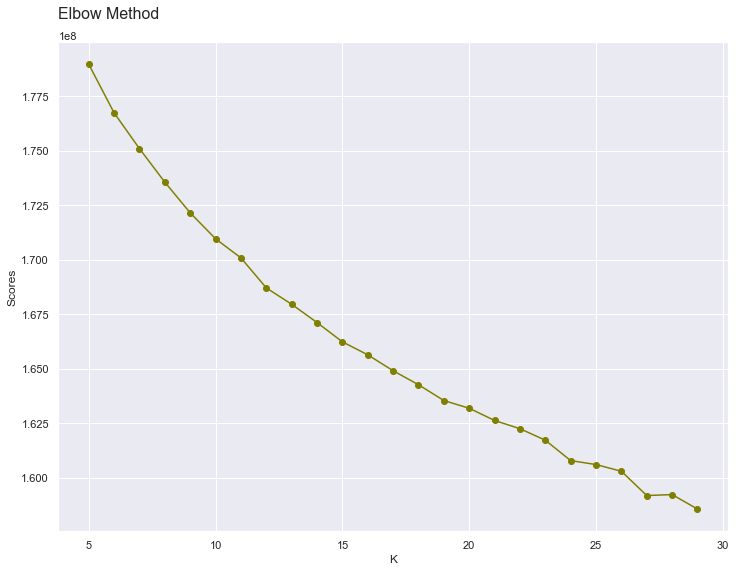

In [30]:
# Investigate the change in within-cluster distance across number of clusters.
centers = np.array(range(k_start, k_end))
plt.figure(figsize=(12,9))
plt.plot(centers, scores, linestyle='-', marker='o', color='olive')
plt.title('Elbow Method \n', size=16, loc='left')
plt.xlabel('K')
plt.ylabel('Scores')
#plt.show()
plt.savefig('elbow_10_40')

In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X_pca)
labels_a = model.predict(X_pca)

### d) Clustering the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = pd.read_csv('data/customers_clean.csv')
cu_X = feat_transform(customers_clean)
pca_c, X_pca_c = do_pca(cu_X,num_comps)
labels_c = model.predict(X_pca_c)

feat_transform


### e) Comparing Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In the next step, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Considering the proportion of persons in each cluster for the general population, and the proportions for the customers, it is shown, that that the company's customer base is not universal. There are only particular segments of the population that are interested in the company's products. There is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [154]:
azdias_clean['Cluster'] = labels_a
customers_clean['Cluster'] = labels_c

df_az = azdias_clean
df_cu = customers_clean

In [63]:
def plot_2(df1,df2, col):
    """
    plots two countplots of the two dataframes of a random column
    INPUT: two dataframes with high and low NaN proportion
           col string
    """
    plt.figure(figsize=(12,12))
    plt.subplot(211)
    ax = sns.countplot(x = col,data=df1)
    plt.title("General Population \n", size=16, loc='left')
    plt.subplot(212)
    ax = sns.countplot(x = col,data=df2)
    plt.title("Customers \n", size=16, loc='left')
    plt.tight_layout()

In [122]:
def plot_3(df1, df2, col):
    """
    plots two countplots of the two dataframes of a random column
    INPUT: two dataframes with high and low NaN proportion
           col string
    """
    g = df1.reset_index()[['index', col]].groupby(col).count()
    g['proportion'] = [np.round(x / df1.shape[0], 2) for x in g['index']]
    c = df2.reset_index()[['index', col]].groupby(col).count()
    c['proportion'] = [np.round(x / df2.shape[0], 2) for x in c['index']]
    
    g['dataset'] = "General Population"
    c['dataset'] = "Customers"
    df = pd.concat([g,c],axis=0).reset_index()
    plt.figure(figsize=(16,20))
    sns.catplot(x='Cluster',y='proportion', hue="dataset", 
            kind="bar", data=df)._legend.remove()
    plt.title("Cluster Comparison", size=16, loc='left')
    plt.legend(loc='upper left', frameon=False)
    plt.tight_layout();

<Figure size 1152x1440 with 0 Axes>

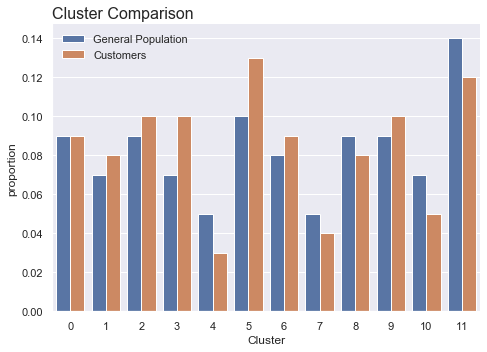

In [123]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plot_3(df_az,df_cu,'Cluster')

In [166]:
def describe_cluster(df1,df2,c):
    """
    plots two countplots of the two dataframes of a random column
    INPUT: two dataframes with high and low NaN proportion
           col string
    """
    df1_T = df1[df1['Cluster']==c].describe().T.sort_values(by='50%',ascending=False)['50%']
    df2_T = df2[df2['Cluster']==c].describe().T.sort_values(by='50%',ascending=False)['50%']
    df_concat = pd.concat([df1_T,df2_T],axis=1).dropna()
    df_concat.columns = ['general_median', 'customer_median']
    df_concat['difference'] = np.abs(df_concat.general_median - df_concat.customer_median)
    df_concat = df_concat.sort_values(by='difference', ascending=False)
    return df_concat.head(10)
    #return df1_T, df2_T

In [167]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
describe_cluster(df_az,df_cu,5)

,general_median,customer_median,difference
ALTER_HH,18.0,10.0,8.0
SEMIO_RAT,6.0,2.0,4.0
SEMIO_LUST,3.0,7.0,4.0
FINANZ_ANLEGER,5.0,1.0,4.0
FINANZ_MINIMALIST,1.0,5.0,4.0
PJ_DEKADE,5.0,1.0,4.0
SEMIO_PFLICHT,6.0,2.0,4.0
SEMIO_VERT,2.0,6.0,4.0
SEMIO_DOM,7.0,3.0,4.0
SEMIO_KAEM,6.0,3.0,3.0


In [168]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
describe_cluster(df_az,df_cu,11)

,general_median,customer_median,difference
ZABEOTYP,3.0,1.0,2.0
CAMEO_DEUG_2015,4.0,2.0,2.0
REGIOTYP,5.0,3.0,2.0
SEMIO_ERL,6.0,4.0,2.0
EWDICHTE,2.0,4.0,2.0
KBA13_KMH_0_140,3.0,1.0,2.0
HH_EINKOMMEN_SCORE,4.0,2.0,2.0
KBA13_SEG_VAN,3.0,4.0,1.0
KBA13_SEG_OBEREMITTELKLASSE,3.0,4.0,1.0
KBA13_KW_60,3.0,2.0,1.0


**Overrepresentation in the customer data:**

* ALTER_HH: The most obvious difference is the age: the customer is in median 40 years older than the general population
* SEMIO_RAT: Affinity indicating in what way the person is of a rational mind; the general population has a very low affinity to be of a rational mind, in contrast to the customer, which has a very high affinity 
* SEMIO_LUST: Affinity indicating in what way the person is sensual minded; the general population has a high affinity to be sensual minded, the customer the lowest.

**Underrepresentation in the customer data:**

* ZABEOTYP: Typification of energy consumers; The general population is on median fair supplied, the customer green.
* CAMEO_DEUG_2015: the general population is on median consumption-oriented middleclass, the customer from the upper middleclass



## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### a) Preprocessing the Data

In [356]:
# Loading data
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=',')
del mailout_train['Unnamed: 0']
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=',')
del mailout_test['Unnamed: 0']
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [357]:
# Dropping LNR identifier:
del mailout_train['LNR']

lnr = mailout_test['LNR']
del mailout_test['LNR']

In [358]:
df_y = mailout_train['RESPONSE']
df_X = mailout_train.drop('RESPONSE',axis=1)

In [372]:
# cleaning data
train, test = clean_data_svl(df_X, mailout_test)
train.head()

Shape of dataset befor clean up:  (85795, 368)
Convert Missing to NaN
Drop Columns with NaN
outlier_col_drop: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'KBA05_ANTG3', 'KBA05_ANTG4', 'TITEL_KZ']
categorical encoding
cat_encode: ['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D1

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,AGER_TYP_1.0,AGER_TYP_2.0,...,PJ_STAAT_1.0,PJ_STAAT_0.0,PJ_STAAT_2.0,PJ_STAAT_2.0,PJ_STAAT_1.0,PJ_STAAT_1.0,PJ_STAAT_0.0,PJ_STAAT_0.0,PJ_STAAT_2.0,PJ_STAAT_2.0
0,15.0,0.0,0.0,1.0,13.0,0.0,390.0,1992.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,2.0,1.0,0.0,586.0,1994.0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,NaN,0.0,0.0,1.0,0.0,297.0,1995.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,0.0,0.0,2.0,4.0,0.0,373.0,1992.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,53.0,0.0,0.0,1.0,44.0,0.0,285.0,1992.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [373]:
# prepairing data
df_y.shape, train.shape

((42962,), (42962, 2228))

In [374]:
def feat_transform_svl(df):
    """
    Impute median for missing values
    INPUT: dataframe
    OUTPUT scaled dataframe
    """
    print("feat_transform")
    imp = SimpleImputer(missing_values=float("NaN"), strategy="most_frequent", copy = False)
    X = pd.DataFrame(imp.fit_transform(df))
    X.columns = df.columns
    X.index = df.index
    return X

In [376]:
# Apply feature transformation, but no PCA
X = feat_transform_svl(train)
test = feat_transform_svl(test)

feat_transform
feat_transform


In [324]:
# SMOTE algorithm for upsampling imbalanced dataset before train-val-split
#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_sample(X, df_y)
#print(np.bincount(y_res))

In [377]:
# Train - Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, df_y, test_size=0.2, random_state=42)

### b) Compareing different models

In [378]:
def build_roc_auc(name, model, X_train, X_val, y_train, y_val):
    '''
    INPUT:
    name: name of the model
    model: an sklearn instantiated model
    X_train: the training data
    y_train: the training response values (must be categorical)
    X_val: the valuation data
    y_val: the valuation response values (must be categorical)
    OUTPUT:
    auc: returns auc as a float
    prints the roc curve
    '''
    
    y_preds = model.fit(X_train, y_train).predict_proba(X_val)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_val)):
        fpr[i], tpr[i], _ = roc_curve(y_val, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) - {} \n'.format(name), size=14, loc='left')
    plt.show();
    
    return roc_auc_score(y_val, np.round(y_preds[:, 1]))

In [379]:
# prepare multible models for evalutation
models = []
#models.append(('RAF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))

In [380]:
# evaluate each model in turn
def eval_models(models, X, X_val, y, y_val):
    results = []
    names = []
    scoring = 'roc_auc'
    for name, model in models:
        print("===============================================================================================")
        print("Start evaluating {}".format(name))
        # Evaluate models:
        kfold = StratifiedKFold(n_splits=2, random_state=42)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = '{} Cross_Val_Score: AUC results mean = {}; AUC results std = {}'.format(name, cv_results.mean(), cv_results.std())
        # Fit models
        roc_auc_scr = build_roc_auc(name, model, X, X_val, y, y_val) 
        print(msg)
        #print("ROC_AUC from graph: {}".format(roc_auc_scr))

Start evaluating ADA


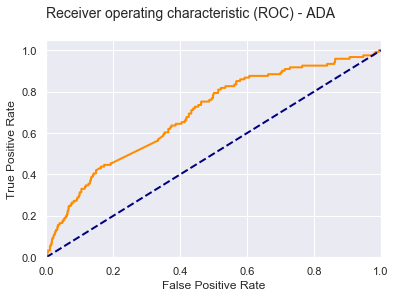

ADA Cross_Val_Score: AUC results mean = 0.6971794457492915; AUC results std = 0.011392405562012708


In [381]:
eval_models(models, X_train, X_val, y_train, y_val)

### c) Optimization of the best model

In [331]:
# Optimize the Random Forest Classifier using GridSearchCV
#param_grid = {"criterion" : ["gini", "entropy"],
#              "n_estimators": [50, 100, 200]}

#param_grid = {"criterion" : ["gini"],
#              "n_estimators": [500]}

#RAF = RandomForestClassifier()

# running grid search
#kfold = StratifiedKFold(n_splits=5, random_state=42)
#RAF_model = GridSearchCV(RAF, param_grid=param_grid, scoring='roc_auc', cv=kfold)

#RAF_model.fit(X_train, y_train)

In [ ]:
print(RAF_model.best_score_)
print(RAF_model.best_estimator_)

In [ ]:
y_preds_raf_val = RAF_model.predict_proba(X_val)
roc_auc_score(y_val, np.round(y_preds_raf_val[:, 1]))

In [382]:
# Optimize the AdaBoostClassifier using GridSearchCV
#param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
#              "base_estimator__splitter" :   ["best", "random"],
#              'learning_rate': [0.1, 1.0],
#              "n_estimators": [50, 100, 200]
#             }
#param_grid = {"base_estimator__criterion" : ["entropy"],
#              "base_estimator__splitter" : ["random"],
#              'learning_rate': [0.1],
#              "n_estimators": [300, 500]
#             }

param_grid = {"base_estimator__criterion" : ["entropy"],
              "base_estimator__splitter" : ["random"],
              "learning_rate": [0.1],
              "n_estimators": [50]
             }

DTC = DecisionTreeClassifier(random_state = 42, max_features = None, max_depth = 1)

ADA = AdaBoostClassifier(base_estimator = DTC)

# running grid search
kfold = StratifiedKFold(n_splits=5, random_state=42)
ADA_model = GridSearchCV(ADA, param_grid=param_grid, scoring='roc_auc', cv=kfold)

ADA_model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
            

In [383]:
print(ADA_model.best_score_)
print(ADA_model.best_estimator_)

0.7480275400343128
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=42,
         

In [384]:
y_preds_ada_val = ADA_model.predict_proba(X_val)
roc_auc_score(y_val, np.round(y_preds_ada_val[:, 1]))

0.5

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [388]:
preds_02 = ADA_model.predict_proba(test)
submission_2 = pd.DataFrame({'LNR':lnr, 'RESPONSE':preds_02[:,0]})
submission_2.to_csv('ADA_preds_03.csv', index=False)
submission_2.head()

,LNR,RESPONSE
0,1754,0.667015
1,1770,0.665428
2,1465,0.747621
3,1470,0.747530
4,1478,0.752486
